In [1]:
import json
import spacy
import nltk
import numpy as np
from tqdm import tqdm, tqdm_notebook
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import gensim
import seaborn as sns
from xgboost.sklearn import XGBClassifier 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [2]:
with open('../../data/raw/relevant_news_10K.json',encoding="utf8") as f1:
    data1 = json.load(f1)
    
with open('../../data/raw/irrelevant_news_10K.json', encoding = "utf8") as f2:
    data2 = json.load(f2)

In [3]:
#seperate out the various components of the data
headlines = []
summaries = []
sources = []
content = []

for d in data1:
    headlines.append(d['headline'])
    summaries.append(d['summary'])
    sources.append(d['source'])
    content.append(d['content'])
    
for d in data2:
    headlines.append(d['headline'])
    summaries.append(d['summary'])
    sources.append(d['source'])
    content.append(d['content'])

In [5]:
#set labels
label = [[1]]*len(data1)
label.extend([[0]]*len(data2))


In [6]:
# Split it into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(content, label, test_size=0.20, random_state=42, shuffle = True)

### Generate clean data for X_train and X_test

In [8]:
#function to preprocess X_train and X_test
def read_corpus(corpus, tokens_only=False):
    for i, line in tqdm_notebook(enumerate(corpus), total = len(corpus)):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [9]:
%%time
#generate train an test corpus
train_corpus = list(read_corpus(X_train))
test_corpus = list(read_corpus(X_test, tokens_only=True))


CPU times: user 14.6 s, sys: 351 ms, total: 14.9 s
Wall time: 14.9 s


## Create feature vectors from Doc2vec embeddings

In [22]:
#Doc2vec feature vectors
X_train_vector = np.array([model.docvecs[i] for i in range(len(train_corpus))])
X_test_vector = np.array([model.infer_vector(test_corpus[i]) for i in range(len(test_corpus))])

In [20]:
#Wrapper to clean and vectorize data
class doc2Vec:
    
    def fit_transform(data):
        idx = X_train.index(data)
        return np.array(model.docvecs[idx])
    
    def transform(data):
        x = np.array(data)
        if len(x.shape) > 0:
            corpus = list(read_corpus(data, tokens_only=True))
            return np.array([model.infer_vector(corpus[i]) for i in range(len(corpus))])
        else:
            corpus = list(read_corpus([data], tokens_only=True))
            return np.array([model.infer_vector(corpus[0])])
        '''idx = X_test.index(data)
        return np.array([model.infer_vector(test_corpus[idx])])'''
    

In [21]:
vectorize = doc2Vec #instantiate the vector

### Let us load the models

#### XGBoost Classifier

In [114]:
xclas = pickle.load(open("../../models/doc2vec_xgboost_model.sav", 'rb'))

#### Naive Bayes Classifier

In [30]:
gnb = pickle.load(open("../../models/doc2vec_naivebayes_model.sav", 'rb'))

0.61225


#### Logistic Regression

In [32]:
logistic = pickle.load(open("../../models/doc2vec_logistic_model.sav", 'rb'))

0.656


## Now to generate explanation for each model using LIME

In [170]:
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

In [172]:
#set class as relevant and irrelevant for ease of use
class_names = ["irrelevant","relevant"]

#import the explainer
explainer = LimeTextExplainer(class_names=class_names)

In [173]:
#Make pipelines for teh vectorizer and each classifier
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorize, xclas)
d = make_pipeline(vectorize,gnb)
e = make_pipeline(vectorize,logistic)

### Generate random id to explain one random test data point

In [174]:
idx = np.random.random_integers(low=0,high=4000)

## XGBOOST explanation

In [175]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=20)

## Here num_features is the number of top weighted features that we want our explanation to return

In [176]:
print('Document id: %d' % idx)
print('Probability(relevant) =', c.predict_proba(X_test[idx])[0,1])
print('True class: %s' % class_names[Y_test[idx][0]])

Document id: 2623



Probability(relevant) = 0.54925066
True class: irrelevant


In [177]:
exp.as_list()

[('rally', 0.041941022138124555),
 ('journalist', 0.03696112868380821),
 ('events', 0.029112546465044),
 ('Golunov', 0.02667321370469271),
 ('enforcement', 0.02656997137710578),
 ('Ministry', 0.02472608441428271),
 ('charges', 0.02230787164687208),
 ('Minister', 0.020457919565373035),
 ('earlier', 0.02031743837763869),
 ('Court', 0.02019708907899488),
 ('as', 0.01933029441260816),
 ('people', 0.018976523496087624),
 ('source', 0.018758909383858016),
 ('statement', 0.018502286510079093),
 ('support', 0.01704987155467815),
 ('media', 0.016850297130089707),
 ('Interior', -0.014367458265277815),
 ('the', -0.009940497441773508),
 ('June', -0.008202768318504373),
 ('administrative', -0.007733601872382434)]


### Values with negative weights lead to a more irrelevant classification, and values with positive weights lead to a more relevant classification

### To view the same information in a more graphical way we can plot it:

In [ ]:
%matplotlib inline
fig = exp.as_pyplot_figure()

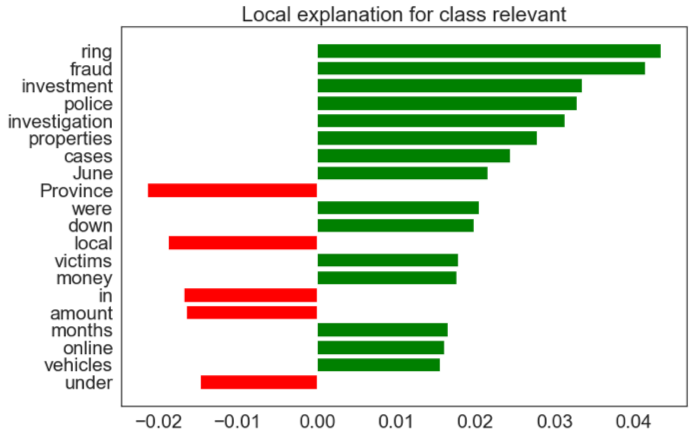

In [2]:
from IPython.display import Image
Image(filename="../../docs/images/Results2.png")

### To view the explanation in context we can view each weighted feature highlighted in the test article

In [ ]:
exp.show_in_notebook(text=True)

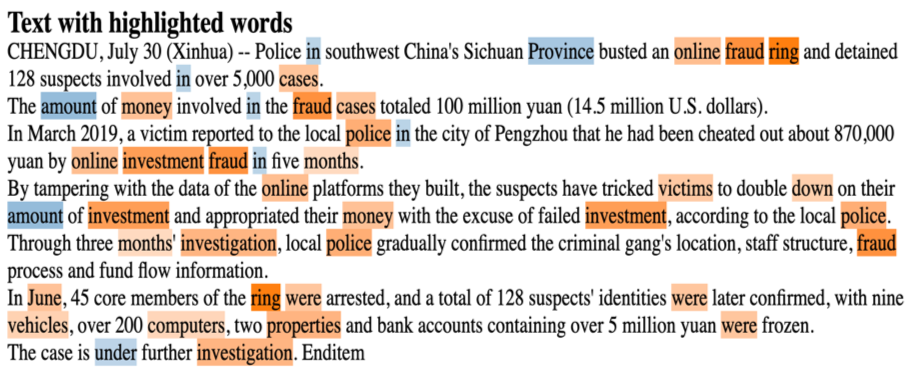

In [3]:
Image(filename="../../docs/images/Results.png")

### Repeating these experiments for Naive Bayes and Logistics Regression we see:

## NAIVE BAYES explanation

In [181]:
print(d.predict_proba(X_test[0]))


[[1.00000000e+00 3.77655471e-10]]


In [182]:
exp = explainer.explain_instance(X_test[idx], d.predict_proba, num_features=10)

print('Document id: %d' % idx)
print('Probability(relevant) =', c.predict_proba(X_test[idx])[0,1])
print('True class: %s' % class_names[Y_test[idx][0]])




Document id: 2623



Probability(relevant) = 0.5578336
True class: irrelevant


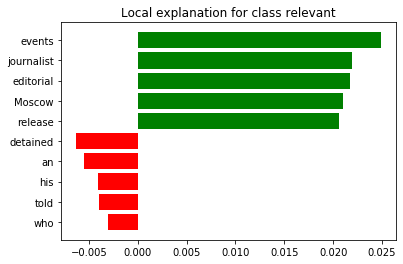

In [184]:


%matplotlib inline
fig = exp.as_pyplot_figure()



In [186]:
exp.show_in_notebook(text=True)

## LOGISTIC REGRESSION EXPLANATION

In [187]:
print(e.predict_proba(X_test[0]))




[[0.5187565 0.4812435]]


In [188]:
exp = explainer.explain_instance(X_test[idx], e.predict_proba, num_features=10)

print('Document id: %d' % idx)
print('Probability(relevant) =', c.predict_proba(X_test[idx])[0,1])
print('True class: %s' % class_names[Y_test[idx][0]])






Document id: 2623



Probability(relevant) = 0.63876224
True class: irrelevant


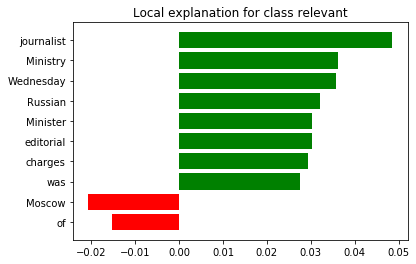

In [190]:

%matplotlib inline
fig = exp.as_pyplot_figure()




In [192]:
exp.show_in_notebook(text=True)

### Thus through LIME we notice that the irrelevan